In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, LinearConstraint, Bounds
import yfinance as yf
import matplotlib.pyplot as plt

In [1]:

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "JPM", "XOM", "PG", "V"]

prices = yf.download(tickers, start = '2015-01-01', auto_adjust=False)['Adj Close']
prices.head()

NameError: name 'yf' is not defined

In [26]:
def weights_clean(weights, rounddp = 6):
    """
    Clean and format portfolio weights for display.
    
    Removes tiny weights (below 1e-6) and formats as a pandas Series
    with proper rounding for readability.
    
    Parameters
    ----------
    weights : array-like
        Raw portfolio weights from optimization
    asset_names : list or pd.Index
        Names of the assets corresponding to weights
    rounddp : int, default 6
        Number of decimal places for rounding
        
    Returns
    -------
    pd.Series
        Cleaned weights with asset names as index, rounded to specified decimals
    """
    weightsclean = np.where(np.abs(weights) < 1e-6, 0, weights)

    weightsclean = pd.Series(weightsclean, tickers)
    weightsclean = weightsclean.round(rounddp)
    return weightsclean

In [27]:
def expectedreturns(prices, geometric = False, days = 252):
    """
    Calculate annualized expected returns from historical price data.
    
    Uses simple arithmetic mean of daily returns, scaled to annual frequency.
    Missing values are handled by dropping rows where all assets are NaN.
    
    Parameters
    ----------
    prices : pd.Series or pd.DataFrame
        Historical price data with dates as index and assets as columns
    compounding: Boolean
        Adjust beetween geometric and arithmetic mean
    days : int, default 252
        Number of trading days per year for annualization
        
    Returns
    -------
    pd.Series
        Annualized expected returns for each asset
        
    Raises
    ------
    TypeError
        If prices is not a pandas Series or DataFrame
    """
    if not isinstance(prices, (pd.Series, pd.DataFrame)):
        raise TypeError("Format prices as a pd.Series")
    returns = prices.pct_change(fill_method=None).dropna(how="all")
    if geometric:
        return (1 + returns).prod() ** (days / returns.count()) - 1
    else:
        return returns.mean() * days

In [28]:
def covariancematrix(prices, days = 252):
    """
    Calculate annualized covariance matrix from historical price data.
    
    Computes sample covariance matrix of daily returns and scales to annual frequency.
    Uses pandas pairwise-complete observations for handling missing data.
    
    Parameters
    ----------
    prices : pd.Series or pd.DataFrame
        Historical price data with dates as index and assets as columns
    days : int, default 252
        Number of trading days per year for annualization
        
    Returns
    -------
    pd.DataFrame
        Annualized covariance matrix with assets as both index and columns
        
    Raises
    ------
    TypeError
        If prices is not a pandas Series or DataFrame
    """
    if not isinstance(prices, (pd.Series, pd.DataFrame)):
        raise TypeError("Formate prices as pd.Series")
    returns = prices.pct_change(fill_method=None).dropna(how='all')
    covariance = returns.cov() * days

    return covariance

In [29]:
def minimumvariance(prices, target_return):
    """
    Find minimum variance portfolio for a given target return.
    
    Solves the optimization problem: min w^T Σ w subject to μ^T w = target_return
    and sum(w) = 1, with optional bounds on individual weights.
    
    Parameters
    ----------
    prices : pd.DataFrame
        Historical price data with dates as index and assets as columns
    target_return : float
        Target annualized return for the portfolio
        
    Returns
    -------
    scipy.optimize.OptimizeResult
        Optimization result object containing:
        - x: optimal portfolio weights
        - fun: minimum variance achieved
        - success: whether optimization succeeded
    """
    if not isinstance(prices, (pd.Series, pd.DataFrame)):
        raise TypeError("Prices should be a pd.Series")
    
    n= len(prices.columns)
    bounds = Bounds(0,1)
    linear_constraint = LinearConstraint(np.ones(n), 1, 1)

    w0 = np.ones(n) / n
    
    exp_ret = expectedreturns(prices)
    
    cov_matrix = covariancematrix(prices)

    target_constraint = {'type': 'eq', 'fun': lambda w: exp_ret.T @ w - target_return}
    
    variance = lambda w: w.T @ cov_matrix @ w

    res1 = minimize(variance, w0, args = (), method = 'SLSQP', bounds=bounds, constraints=[linear_constraint, target_constraint])
    
    return res1

In [30]:
def efficientfrontier(prices, data_points = 250):
    """
    Generate efficient frontier by solving minimum variance problems across target returns.
    
    Parameters
    ----------
    prices : pd.DataFrame
        Historical price data with assets as columns
    data_points : int, default 250
        Number of portfolios to generate along the frontier
        
    Returns
    -------
    tuple of (list, list)
        ef_points : list of (risk, return) tuples for each efficient portfolio
        weight_list : list of weight arrays corresponding to each portfolio
        """
    
    if not isinstance(prices, pd.DataFrame):
        raise TypeError("prices must be a pandas DataFrame")
    exp_ret = expectedreturns(prices)
    cov_matrix = covariancematrix(prices)
    n = prices.columns

    # Constraints and Initial Guess for Problem
    bounds = Bounds(0,1)
    linear_constraint = LinearConstraint(np.ones(len(n)), 1, 1)
    w0 = np.ones(len(tickers)) / len(tickers)

    # Creating the Optimisation Function to find Max. Return Portfolio
    ret = lambda w: -exp_ret.T @ w  # negative so we can find maximum
    max_ret_port = minimize(ret, w0, args=(), method = 'SLSQP', constraints=linear_constraint, bounds=bounds) 

    # Function to find max. variance portfolio
    var = lambda w : w.T @ cov_matrix @ w
    min_var_port = minimize(var, w0, args = (), method = "SLSQP", constraints=linear_constraint, bounds=bounds)

    # Calculating min and max target returns for the EF.
    min_return = exp_ret.T @ min_var_port.x
    max_return = exp_ret.T @ max_ret_port.x 

    trs = np.linspace(min_return, max_return, data_points, True)
    ef_points = []
    weight_list = []

    for tr in trs:
        targ_constr = {'type': 'eq', 'fun': lambda w, target=tr: exp_ret.T @ w - target}

        obj = lambda w: 1/2 * w.T @ cov_matrix @ w
        res1 = minimize(obj, w0, args = (), method = 'SLSQP', bounds=bounds, constraints=(linear_constraint, targ_constr))

        if res1.success:  #  Avoid insuccessful optimisations
            x = res1.x
            ret = exp_ret.T @ x
            risk = np.sqrt(x.T @ cov_matrix @ x)
            ef_points.append((risk, ret))
            weight_list.append(x)
    
    return ef_points, weight_list


In [31]:
def max_sharpe(prices, r_f = 0.0, kmax = 1000, k0 = 1):
    """
    Calculate the maximum Sharpe ratio portfolio using convex optimization. This is solving the optimisation problem 
    called 'Optimal Risky Portfolio' in the Optimisation Methods in Finance. Maths detailed in documentation.

    
    Parameters:
    -----------
    prices : pd.DataFrame
        Historical price data with assets as columns
    r_f : float, default 0.0
        Risk-free rate (annualized)
    kmax : float, default 1000
        Maximum bound for optimization variables
    k0 : float, default 1
        Initial guess for scaling parameter
    
    Returns:
    --------
    tuple : (float, pd.Series)
        - Maximum Sharpe ratio value
        - Optimal portfolio weights as pandas Series
    """
    cov_matrix = covariancematrix(prices)
    expret = expectedreturns(prices)
    n = len(prices.columns)

    # Creating the object we are optimising by adding kappa as a variable to the weight array
    x0 = np.ones(n) / n 
    w0 = np.append(x0, k0)

    # Defining the objective function
    def obj(w):
        w = w[:n] # Not including kappa in the Variance calculation.
        return w.T @ cov_matrix @ w
    
    constraints = (
        {'type': 'eq', 'fun': lambda w: (expret - r_f).T @ w[:n] - 1}, 
        {'type': 'eq', 'fun': lambda w: np.sum(w[:n]) - w[-1]}
    ) # Explained in documentation.

    lb = [0] * n + [1e-6] # Using 1e-6 as a minimum kappa value, not including shorting.
    ub = [kmax] * n + [kmax]
    
    bounds = Bounds(lb=lb, ub=ub)

    wopt = minimize(obj, w0, args= (), method = 'SLSQP', bounds = bounds, constraints=constraints)

    invertedw = wopt.x[:n] / wopt.x[-1] # Inverting weight transformation done with kappa

    # Calculating Sharpe ratio
    value = (expret.T @ invertedw - r_f) / np.sqrt(invertedw.T @ cov_matrix @ invertedw)
    
    return value, pd.Series(invertedw, tickers)

In [32]:
def plotting(prices, maxsharpe = False):
    """
    Plot the efficient frontier, and Sharpe ratio max
    
    Parameters:
    -----------
    prices : pd.DataFrame
        Historical price data with assets as columns
    maxsharpe : Boolean
        Include the max sharpe calculation and label

    Output:
    -----------
    matplotlib graph.
    """

    ef = efficientfrontier(prices)
    exp_ret = expectedreturns(prices)
    cov_matrix = covariancematrix(prices)
    ms = max_sharpe(prices)

    if maxsharpe:
        value, weights = ms
        returns = exp_ret.T @ weights.values
        risk = np.sqrt(weights.values.T @ cov_matrix @ weights.values)
        plt.scatter(risk, returns, marker ='d', c='r', s = 100, label=f"Max Sharpe: {value:.2f}")

    ef_points, _ = ef
    x, y = zip(*ef_points)
    plt.plot(x,y, label = 'Efficient Frontier')
    plt.title("Efficient Frontier")
    plt.xlabel("Risk")
    plt.ylabel("Expected Return")
    plt.legend()
    plt.show()

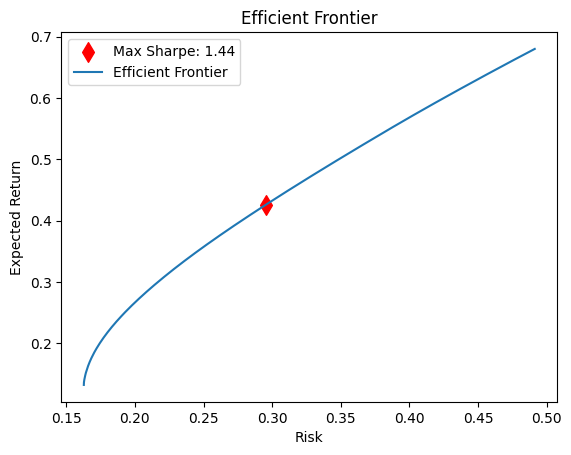

In [33]:
plotting(prices,True)

In [34]:
value, weights = max_sharpe(prices)

print(f"The maximum Sharpe value is: {value:.4f}")
print(f"The optimal portfolio is \n {weights_clean(weights)}")

The maximum Sharpe value is: 1.4426
The optimal portfolio is 
 AAPL     0.000000
MSFT     0.130786
GOOGL    0.000000
AMZN     0.176263
META     0.000000
NVDA     0.011502
JPM      0.480046
XOM      0.201403
PG       0.000000
V        0.000000
dtype: float64
